In [2]:
%load_ext autoreload
%autoreload 2

import torch
from pathlib import Path
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dir_img = Path('./data/train/')
dir_mask = Path('./data/train_masks/')

# Otsu's Segmentation
One of the simplest forms of image segmentation is Otsu's segmentation, which tries to find the optimal threshold to seperate two classes with a binary threshold. There is no learning involved, the algorithm only considers a single image and tries to minimize
$$
    \sigma^2_w(t) = w_0(t)\sigma^2_0(t) + w_1(t)\sigma^2_1(t)
$$
where $w_0$ and $w_1$ is the probability of a pixel belonging to a classes $0$ and $1$ which are seperated by the threshold $t$, and $\sigma_0^2$ and $\sigma_1^2$ are the variances of these classes. (https://engineering.purdue.edu/kak/computervision/ECE661.08/OTSU_paper.pdf)
<br><br>
Since the true label is never consider, all image processing techniques and hyperparameters must be tuned manually. Otsu's segmentation is a good baseline for testing if machine learning is necessary to solve the problem, in this case we can see by looking at the training data that a thresholding algorithm won't work in all cases as some contextual information is required, but the validation score our manual algorithm achieves can be a useful baseline for determining if our more advanced algorithms are working.

#### Step 1. Process and Prepare Data
We're going to be using PyTorch later so we need to get our data setup as DataLoaders. We do a 90% train, 10% validation split with random training and a batch size of 1.

In [3]:
from utils.data_loading import HubmapDataset
from torch.utils.data import DataLoader
import torch
from torch.utils.data import DataLoader, random_split
import os

dataset = HubmapDataset(dir_img, dir_mask, scale=0.5, do_transform=False)

# 3. Split into train / validation partitions
n_val = int(len(dataset) * 0.1)
n_train = len(dataset) - n_val
train_set, val_set = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(0))

# 4. Create data loaders
loader_args = dict(batch_size=1,
                    num_workers=os.cpu_count(), pin_memory=True)
train_loader = DataLoader(train_set, shuffle=True, **loader_args)
val_loader = DataLoader(val_set, shuffle=False,
                        drop_last=True, **loader_args)


#### Step 2. Define The Handcrafted Model
The model separates an images channels and recombines with different weighting to try and pick the most important colours to this problem. Then a Gaussian blur is applied to reduce noise. Otsu's threshold is then applied to separate the image into two classes, which map to 0 and 1. Two hyperparameters are included, channels and blur, which need to be optimized to best suit this problem.

In [4]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from utils.utils import plot_img_and_mask
import torch
from functools import partial

def model(xs, **params):
    xs = xs.cpu().numpy()

    if "channels" not in params:
        params["channels"] = np.array([1,0.1,0.1])
    if "blur" not in params:
        params["blur"] = 11
        
    masks = []
    for x in xs:
        # Choose channels
        r,g,b = x[0],x[1],x[2]
        rm,gm,bm = params["channels"][0],params["channels"][1],params["channels"][2]
        x = np.array([r*rm,g*gm,b*bm]).transpose(1,2,0)

        # Remove some noise
        x = cv2.GaussianBlur(x,(params["blur"],params["blur"]),cv2.BORDER_DEFAULT)

        # Convert to grayscale in preparation for thresholding
        gray = np.uint8(cv2.cvtColor(x*255,cv2.COLOR_RGB2GRAY))

        # Apply otsu's thresholding
        ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        masks.append(thresh/255)
    return torch.tensor(np.array(masks)).to(device=device, dtype=torch.float32)

#### Step 3. Hyper-parameter Tuning
We can do a simple grid search over different blur kernels, keeping track of the validation score for each value. After plotting we can see that increasing kernel sizes improves the score IoU (we may need to look at other metrics), up to a point.

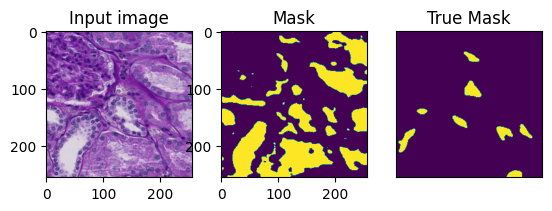

In [5]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from utils.utils import plot_img_and_mask
import torch
from functools import partial

# Example image
x, y_true = dataset[0]['image'], dataset[0]['mask']

y_pred = model(x.unsqueeze(0))

x = x.cpu().numpy().transpose((1,2,0))
y_true = y_true.squeeze().cpu().numpy()
y_pred = y_pred.squeeze().cpu().numpy()
plot_img_and_mask(x,y_pred,y_true)

# Grid search for best channels hyper-parameter
# from evaluate import evaluate

# blurs = np.linspace(1,13,7)
# scores = []
# for blur in blurs:
#     score = evaluate(partial(model, blur=int(blur)), val_loader, device, IoUThreshold=0.1)['mAP'].item()
#     scores += [score]

# import matplotlib.pyplot as plt
# plt.plot(blurs, scores)
# plt.title("IoU for Different Gaussian Blur Sizes")
# plt.show()

In [9]:
from evaluate import evaluate

eval = evaluate(model, val_loader, device)
for stat,val in eval.items():
    print(f"{stat}: {val}")

mAP: 0.0
BCE: 0.8873030656685859
IoU: 0.05712735280394554


We could then perform a grid-search to optimize all possible hyper-paramters, but our model will always be limited because it can never understand context. We need a model which has a wider view and doesn't need to be manually trained. This could be achieved with a neural network which directly connects the input pixels (512x512) to the predicted mask (512x512). Unfortunately, there are just too many parameters in such a model making overfitting and training issues, especially as we need to process larger images which require more context. This is where fully convolutional neural networks come in.

# ErfNet
ErfNet is a conveolution neural network designed for semantic segmentation with low computational requirements.

In [13]:
from erfnet import ErfNet
from train import train_model

model = ErfNet(n_channels=3).to(device)
train_model(model, device, "ErfNet", img_scale=0.25)

BCE,█▂▁▁▁
IoU,▁▅██▅
epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
epoch loss,█▂▂▁▁
learning rate,▁▁▁▁▁
mAP,▁▂▄█▂
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,▅▃▃▃▃▂▂▅▄▂▂▂▃█▂▆▁▃▃▁▃▁▆▅▂▂▃▄▆▂▁▂▂▁▃▂▂▁▃▄
BCE,0.27771
IoU,0.09693
epoch,5


Epoch 5/5: 100%|██████████| 1470/1470 [03:52<00:00,  6.32img/s, loss (batch)=0.0764]


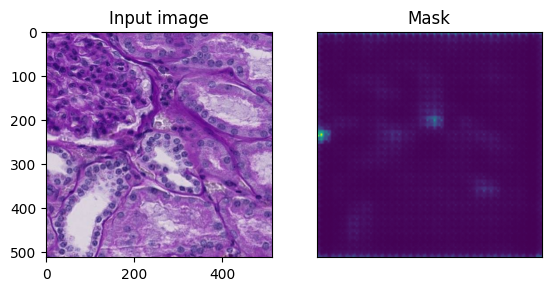

In [6]:
from PIL import Image, ImageOps
from predict import predict_img
from utils.utils import plot_img_and_mask
from erfnet import ErfNet

img = Image.open('data/train/0006ff2aa7cd.tif')

net = ErfNet(n_channels=3).to(device)
state_dict = torch.load('checkpoints/modelvolcanic-voice-23_epoch4.pth', map_location=device)
net.load_state_dict(state_dict)

mask = predict_img(net=net, full_img=img, device=device, scale_factor=0.25)
plot_img_and_mask(img, mask)

## U-Net
Similar to ErfNet, UNet works by repeatedly downsampling our input into a larger and larger number of channels. Downsampling increases the receptive field of each 3x3 conv the Increasing the number of channels is an attempt to increase

In [12]:
from unet import UNet
from train import train_model

model = UNet(n_channels=3).to(device)
train_model(model, device, "UNet", img_scale=0.25)

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: patricklachlanbell. Use `wandb login --relogin` to force relogin


Epoch 5/5: 100%|██████████| 1470/1470 [14:59<00:00,  1.63img/s, loss (batch)=0.141] 


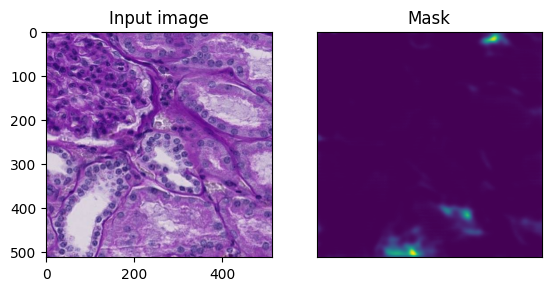

In [8]:
from PIL import Image, ImageOps
from predict import predict_img
from utils.utils import plot_img_and_mask
from unet import UNet

img = Image.open('data/train/0006ff2aa7cd.tif')

net = UNet(n_channels=3).to(device)
state_dict = torch.load('checkpoints/modelchocolate-planet-21_epoch5.pth', map_location=device)
net.load_state_dict(state_dict)

mask = predict_img(net=net, full_img=img, device=device, scale_factor=0.25)
plot_img_and_mask(img, mask)